In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import anndata as ad
import scanpy as sc
import pandas as pd
import squidpy as sq
import seaborn as sns
import numpy as np
from scipy import stats

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform

In [2]:
in_dir = "../../results/10_stereo_seq/10_neighbor_enrichment"
out_dir = "../../results/10_stereo_seq/13_neighbor_enrichment"

os.makedirs(out_dir, exist_ok=True)

In [3]:
def compute_enrichment(dists, 
                       n_neighbors, 
                       cat_key="cell_type",
                       source_cell_type="Fibroblasts", 
                       target_cell_type="Macrophages"):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='precomputed')
    nbrs.fit(dists)
    
    neighbors = nbrs.kneighbors(return_distance=False)
    
    # get cell type
    cell_types = adata.obs[cat_key].tolist()
    indices = (adata.obs[cat_key] == source_cell_type).values.nonzero()[0]
    
    proportion_list = []
    for idx in indices:
        # compute proportion of target cell type
        n_targets = 0.0
        for i in neighbors[idx]:
            if cell_types[i] == target_cell_type:
                n_targets += 1

        proportion_list.append(n_targets / n_neighbors)
        
    return np.mean(proportion_list)

<Axes: xlabel='n_neighbors', ylabel='obs_exp'>

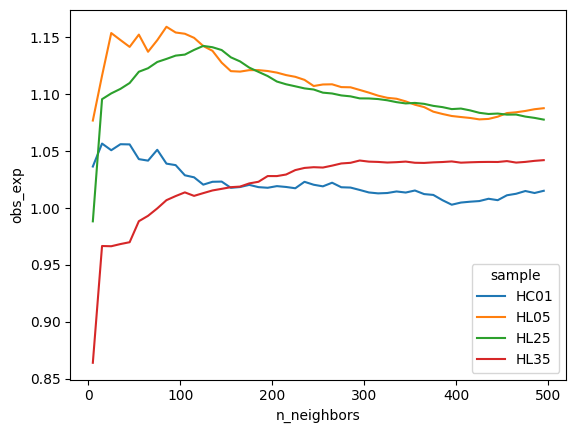

In [4]:
sample_list, n_neighbors_list, obs_enrich_list, exp_enrich_list = [], [], [], []
for sample in ["HC01", "HL05", "HL25", "HL35"]:
    adata = sc.read_h5ad(f"{in_dir}/{sample}.h5ad")
    adata.obs["cell_type_shuffle"] = np.random.permutation(adata.obs["cell_type"])
    
    dists = squareform(pdist(adata.obsm["spatial"], metric="euclidean"))
    
    for n_neighbors in range(5, 500, 10):
        obs_enrich = compute_enrichment(dists, n_neighbors=n_neighbors, cat_key="cell_type")
        exp_enrich = compute_enrichment(dists, n_neighbors=n_neighbors, cat_key="cell_type_shuffle")
        
        sample_list.append(sample)
        n_neighbors_list.append(n_neighbors)
        obs_enrich_list.append(obs_enrich)
        exp_enrich_list.append(exp_enrich)
        
df = pd.DataFrame(data={"sample": sample_list, 
                        "n_neighbors": n_neighbors_list, 
                        "obs_proportion": obs_enrich_list,
                        "exp_proportion": exp_enrich_list,
                        "source_cell_type": "Fibroblasts",
                        "target_cell_type": "Macrophages"})

df["obs_exp"] = df['obs_proportion'] / df['exp_proportion']
df.to_csv(f"{out_dir}/enrichment_fib_mac.csv")
sns.lineplot(data=df, x="n_neighbors", y="obs_exp", hue="sample")

<Axes: xlabel='n_neighbors', ylabel='obs_exp'>

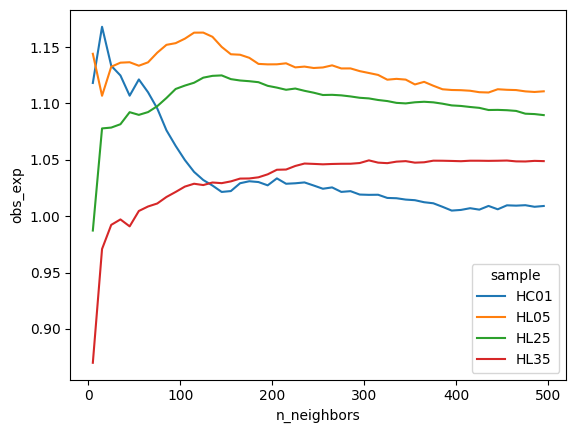

In [5]:
sample_list, n_neighbors_list, obs_enrich_list, exp_enrich_list = [], [], [], []
for sample in ["HC01", "HL05", "HL25", "HL35"]:
    adata = sc.read_h5ad(f"{in_dir}/{sample}.h5ad")
    adata.obs["cell_type_shuffle"] = np.random.permutation(adata.obs["cell_type"])
    
    dists = squareform(pdist(adata.obsm["spatial"], metric="euclidean"))
    
    for n_neighbors in range(5, 500, 10):
        obs_enrich = compute_enrichment(dists, n_neighbors=n_neighbors, cat_key="cell_type")
        exp_enrich = compute_enrichment(dists, n_neighbors=n_neighbors, cat_key="cell_type_shuffle")
        
        sample_list.append(sample)
        n_neighbors_list.append(n_neighbors)
        obs_enrich_list.append(obs_enrich)
        exp_enrich_list.append(exp_enrich)
        
df1 = pd.DataFrame(data={"sample": sample_list, 
                        "n_neighbors": n_neighbors_list, 
                        "obs_proportion": obs_enrich_list,
                        "exp_proportion": exp_enrich_list,
                        "source_cell_type": "Macrophages",
                        "target_cell_type": "Fibroblasts"})

df1["obs_exp"] = df1['obs_proportion'] / df1['exp_proportion']
df1.to_csv(f"{out_dir}/enrichment_mac_fib.csv")
sns.lineplot(data=df1, x="n_neighbors", y="obs_exp", hue="sample")